In [1]:
!pwd

/home/nicolasf/operational/ICU/development/hotspots/code/ICU_Water_Watch/notebooks/ICU_forecast_table


In [2]:
%matplotlib inline

### os
import os
import sys

### datetimes
from datetime import datetime, timedelta

### scipy
import numpy as np
import pandas as pd
import xarray as xr
import geopandas as gpd
import cartopy.crs as ccrs
import dask
from dask.diagnostics import ProgressBar
from tqdm import tqdm

### plotting
from matplotlib import pyplot as plt
import matplotlib
import seaborn as sns


In [3]:
import pathlib

HOME = pathlib.Path.home()
CWD = pathlib.Path.cwd()


In [4]:
sys.path.append('../../') 

In [5]:
from ICU_Water_Watch import utils

In [6]:
def compare(df): 
    df = df.dropna()
    acc = (df.forecast == df.obs).sum() / len(df)
    return acc

### Parameters 

In [7]:
period = 'seasonal'

In [8]:
dpath = CWD.parents[1].joinpath("outputs/ICU_validation/")

### figures 

In [9]:
fig_path = CWD.parents[1].joinpath("figures/ICU_validation/")

### outputs 

In [10]:
outputs_path = CWD.parents[1].joinpath("outputs/ICU_validation/admin")

### read the file with the countries and the admin boundaries 

In [11]:
coastlines_dpath = pathlib.Path('/home/nicolasf/operational/ICU/development/hotspots/data/shapefiles/Admin_boundaries/Coastlines')

In [12]:
shapefile = gpd.read_file(coastlines_dpath.joinpath('ICU_admin_geometries0_360.shp'))

In [13]:
shapefile.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [14]:
shapefile.columns

Index(['id', 'Country', 'Admin_boun', 'geometry'], dtype='object')

In [15]:
country_col = 'Country'
admin_col = 'Admin_boun'

In [16]:
shapefile.loc[:,f"{admin_col}"] = shapefile.loc[:,f"{admin_col}"].str.replace("'","")

In [17]:
countries = shapefile.loc[:,'Country'].unique()

### Parameters for PAPERMILL

In [18]:
country = 'New Caledonia'
admin = 'North Province'

In [19]:
# Parameters
country = "Marshall Islands"
admin = "Northern Marshall Islands"


In [20]:
lfiles = list(outputs_path.glob(f"{utils.sanitize_name(country)}_{utils.sanitize_name(admin)}_seasonal_*_tercile_probs_and_obs.csv"))

In [21]:
MME = []

for fname in lfiles: 
    
    if "METEO_FRANCE" in str(fname): 
        
        GCM = 'METEO_FRANCE'
        
    else: 
        
        GCM = str(fname).split('_')[-5]
    
    data = pd.read_csv(fname, index_col=0, parse_dates=True)
    
    obs = data.iloc[:, -1]
    
    data = data.iloc[:,:-1]
        
    cols = [eval(x) for x in data.columns]
    data.columns = pd.MultiIndex.from_tuples(cols)
    data = data.to_xarray()
    data = data.expand_dims({'GCM':[GCM]})
    
    MME.append(data)

In [22]:
MME = xr.concat(MME, dim='GCM')

In [23]:
MME

<xarray.Dataset>
Dimensions:  (time: 286, GCM: 8)
Coordinates:
  * time     (time) datetime64[ns] 1993-03-01 1993-04-01 ... 2016-12-01
  * GCM      (GCM) <U12 'JMA' 'UKMO' 'NCEP' 'DWD' ... 'ECCC' 'CMCC' 'ECMWF'
Data variables:
    (3, 1)   (GCM, time) float64 10.0 50.0 80.0 80.0 50.0 ... 8.0 8.0 28.0 28.0
    (3, 2)   (GCM, time) float64 60.0 30.0 20.0 20.0 ... 16.0 36.0 44.0 32.0
    (3, 3)   (GCM, time) float64 30.0 20.0 0.0 0.0 10.0 ... 76.0 56.0 28.0 40.0
    (4, 1)   (GCM, time) float64 10.0 50.0 100.0 50.0 20.0 ... 4.0 16.0 20.0 8.0
    (4, 2)   (GCM, time) float64 40.0 30.0 0.0 50.0 50.0 ... 24.0 28.0 48.0 64.0
    (4, 3)   (GCM, time) float64 50.0 20.0 0.0 0.0 30.0 ... 72.0 56.0 32.0 28.0
    (5, 1)   (GCM, time) float64 10.0 40.0 50.0 10.0 0.0 ... 0.0 24.0 16.0 16.0
    (5, 2)   (GCM, time) float64 20.0 40.0 30.0 50.0 ... 36.0 16.0 44.0 40.0
    (5, 3)   (GCM, time) float64 70.0 20.0 20.0 40.0 ... 64.0 60.0 40.0 44.0

In [24]:
quantiles = 'tercile'

In [25]:
MME_mean = MME.mean('GCM')

In [26]:
MME = xr.merge([MME, MME_mean.expand_dims({'GCM':['MME']})]) 

In [27]:
GCMs = ['ECMWF', 'UKMO', 'METEO_FRANCE', 'DWD', 'CMCC', 'NCEP','JMA'] + ['MME']

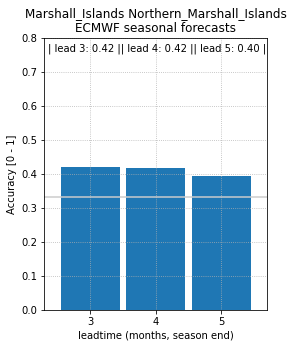

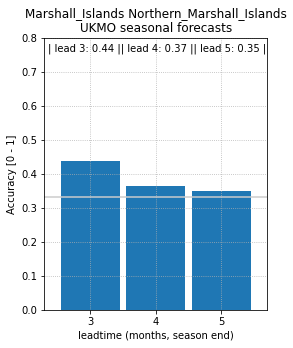

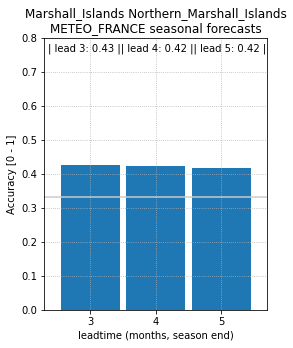

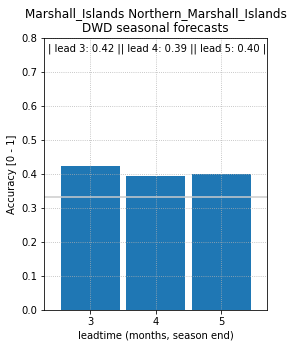

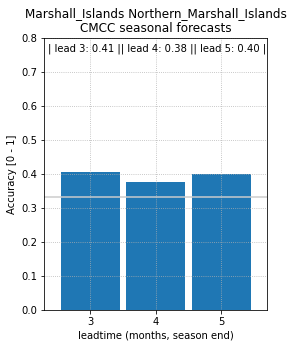

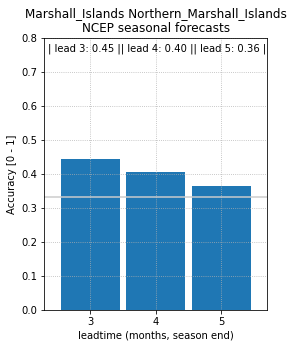

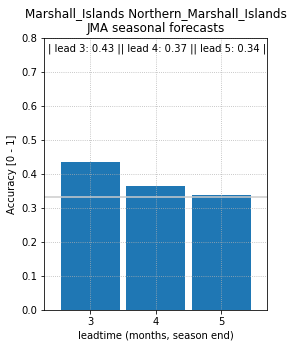

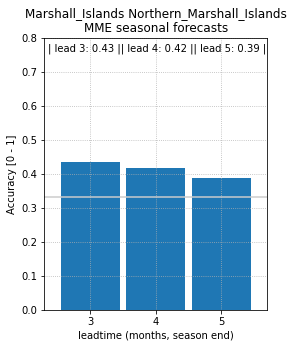

In [28]:
for GCM in GCMs: 
    
    dset = MME.sel(GCM=GCM).squeeze()
    
    dset = dset.drop("GCM")
    
    df = dset.to_pandas()
    
    steps = np.unique(df.columns.get_level_values(0)) 
    
    validation = {}
    validation_seasonal = {}

    validation[f"{utils.sanitize_name(country)}_{utils.sanitize_name(admin)}"] = {}
    
    validation_seasonal[f"{utils.sanitize_name(country)}_{utils.sanitize_name(admin)}"] = {}

    for step in steps: 

        df_hindcasts = df.xs(step, axis=1, level=0)

        df_hindcasts.index = df_hindcasts.index + pd.offsets.MonthBegin(step)

        df_hindcasts_most_likely_category = df_hindcasts.idxmax(axis=1)

        #         print(50 * "-")
        #         print(f"\nrelative frequency of the {quantiles} categories:\n") 
        #         print(pd.value_counts(df_hindcasts_most_likely_category) / len(df_hindcasts_most_likely_category))

        df_merge = pd.concat([df_hindcasts_most_likely_category.to_frame(name='forecast'), obs.to_frame(name='obs')], axis=1).dropna()

        acc = compare(df_merge)

        acc_seasonal = df_merge.groupby(df_merge.index.month).apply(compare)

        #         print("\nforecast accuracy\n")
        #         print((df_merge.forecast == df_merge.obs).sum() / len(df_merge))

        validation[f"{utils.sanitize_name(country)}_{utils.sanitize_name(admin)}"][step] = acc 

        validation_seasonal[f"{utils.sanitize_name(country)}_{utils.sanitize_name(admin)}"][step] = acc_seasonal
        
    validation = pd.DataFrame(validation)
    
    # saves the validation to disk 
    
    validation.to_csv(outputs_path.joinpath(f"validation_{utils.sanitize_name(country)}_{utils.sanitize_name(admin)}_{period}_{GCM}_tercile.csv"))
    
    vals = validation.values.flatten()
     
    s = ""
    for i in range(len(steps)): 
        s += f"| lead {steps[i]}: {vals[i]:4.2f} |"

    f = validation.plot(kind='bar', ylabel='Accuracy [0 - 1]', xlabel='leadtime (months, season end)', ylim=[None, 0.8], legend=None, figsize=(4,5), width=0.9) 
    f.axes.set_title(f"{utils.sanitize_name(country)} {utils.sanitize_name(admin)}\n{GCM} {period} forecasts")
    f.axes.axhline(0.3333, color='0.8')
    f.axes.grid(ls=':')
    f.axes.text(0.015, 0.95, s, transform=f.axes.transAxes)
    [l.set_rotation(0) for l in f.axes.xaxis.get_ticklabels()]
    fig = plt.gcf()
    fig.savefig(fig_path.joinpath(f'{utils.sanitize_name(country)}_{utils.sanitize_name(admin)}_{period}_{GCM}_{quantiles}_probs.png'), dpi=200, bbox_inches='tight', facecolor='w')
        